### Enthalpy as a function of temperature and ideal gas behaviour

In [1]:
#import modules

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sympy as sp

In [2]:
#constants
R=8.314
T0 = 298 #kelvin
T = np.linspace(T0,900,1000) #kelvin
DHR_298 = -45.940*2 * 1000 #j/mol
DSR_298=  -198.100 # j/(mol*K)
DGR_298  = DHR_298 - T0 * DSR_298 #j/mol


# initialising and defining arrays
temps = np.linspace(298,900,1000)
H = np.zeros_like(temps)
S = np.zeros_like(temps)
G = np.zeros_like(temps)
P = np.array([0.01,1,10,50,100,200,500])




In [3]:
import numpy as np

def cp_data():
    # CP CONSTANTS at 500 K
    C_N2_500 = {'a': 28.98641,
                'b': 1.853978,
                'c': -9.647459,
                'd': 16.63537,
                'e': 0.000117}

    C_H2 = {'a': 33.066178,
             'b': -11.363417,
             'c': 11.432816,
             'd': -2.772874,
             'e': -0.158558}

    C_NH3 = {'a': 19.99563,
              'b': 49.77119,
              'c': -15.37599,
              'd': 1.921168,
              'e': 0.18974}

    # N2 Cp CONSTANTS 500 - 2000 K
    C_N2_2000 = {'a': 19.50583,
                 'b': 19.88705,
                 'c': -8.598535,
                 'd': 1.369784,
                 'e': 0.527601}

    # Put in list for ease of use
    Cp_data = np.array([C_N2_500, C_N2_2000, C_H2, C_NH3])
    return Cp_data

Cp_data = cp_data()




In [4]:

 def DCp (Cp_data):
  #C_H2 = {key: value * 3 for key, value in Cp_data[2].items()}
  #C_NH3 = {key: value * 2 for key, value in Cp_data[3].items()}
  DCp_500 = {key: 2*Cp_data[3][key] - (Cp_data[0][key] + 3*Cp_data[2][key]) for key in Cp_data[0] }
  DCp_2000 = {key: 2*Cp_data[3][key] - (Cp_data[1][key] + 3*Cp_data[2][key]) for key in Cp_data[2] }

  return DCp_500, DCp_2000

In [5]:


def integration():

  # Define the variable and the polynomial
  A,B,C,D,E,T,T0 = sp.symbols('A B C D E T T0')
  # a + bt + ct^2 + Dt^3 + E/t^2
  ##Enthalpy
  # both cases
  t = T/1000

  H_polynomial =  A + B*t + C*t**2 + D*t**3 +  E*t**(-2)




  # Integrate the for Enthalpy
  #dH = (C(T))dT

  H_integrated = sp.integrate(H_polynomial,(T, T0, T))

  # Integration for Entropy
  # dS = (C(T)/T) dT

  S_polynomial =  H_polynomial / T

  S_integrated = sp.integrate(S_polynomial, (T, T0, T))


  return H_integrated, S_integrated


In [6]:

import numpy as np

def DH(T0, T, DHR_298, DCp_500, DCp_2000):
    A, B, C, D, E = (DCp_500[key] if np.any(T < 500) else DCp_2000[key] for key in ['a', 'b', 'c', 'd', 'e'])

    H = (
        DHR_298 +
        A * T - A * T0 + B * T**2 / 2000 - B * T0**2 / 2000 + C * T**3 / 3000000 - C * T0**3 / 3000000 +
        D * T**4 / 4000000000 - D * T0**4 / 4000000000 + 1000000 * E / T0 - 1000000 * E / T
    )

    return H


In [7]:
def DS(T0,T,DSR_298,DCp_500,DCp_2000):
  A, B, C, D, E = (DCp_500[key] if np.any(T < 500) else DCp_2000[key] for key in ['a', 'b', 'c', 'd', 'e'])


  S = (
  DSR_298 +
  A*np.log(T) - A*np.log(T0) + B*T/1000 - B*T0/1000 +
  C*T**2/2000000 -  C*T0**2/2000000 + D*T**3/3000000000 -
  D*T0**3/3000000000 + 500000*E/T0**2 - 500000*E/T**2)
  return S

In [8]:
def DG(H,S,temps):
    return  H - (temps * S)

In [9]:
def Kp(G,T):
  return np.exp(-G/(R*T))

In [10]:
def vant_hoff(H,DGR_298,T0,temps):
  return np.exp(-DGR_298/(R*T0)) * np.exp( H/R * (1/T0 - 1/temps))


In [11]:
x, p, K = sp.symbols('x p K')

den = 4 - 2*x
P_H2 = ((3*(1-x))/den) * p
P_N2 = (1-x)/den * p
P_NH3 = (2*x/den *p)
equation = P_NH3**2 / (P_N2 * P_H2**3)  - K
solution = sp.simplify(equation)
solution = sp.solve(equation,'x')[1]

In [12]:
def conversion(Kp,P):
 Kp_matrix,P_matrix = np.meshgrid(Kp,P)
 return 1 - 2 * np.sqrt(3 * np.sqrt(3) * np.sqrt(Kp_matrix) * P_matrix / (27 * Kp_matrix * P_matrix**2 - 16) - 4 / (27 * Kp_matrix * P_matrix**2 - 16))


In [13]:
Cp_500,Cp_2000 = DCp(Cp_data)

enthalpies =  DH(T0, T, DHR_298, Cp_500, Cp_2000)

entropies  =  DS(T0,T,DSR_298,Cp_500,Cp_2000)

Gibbs_energies = DG(enthalpies,entropies,temps)

ideal_eqm_constant = Kp(Gibbs_energies,T)

Xe = conversion(ideal_eqm_constant,P)


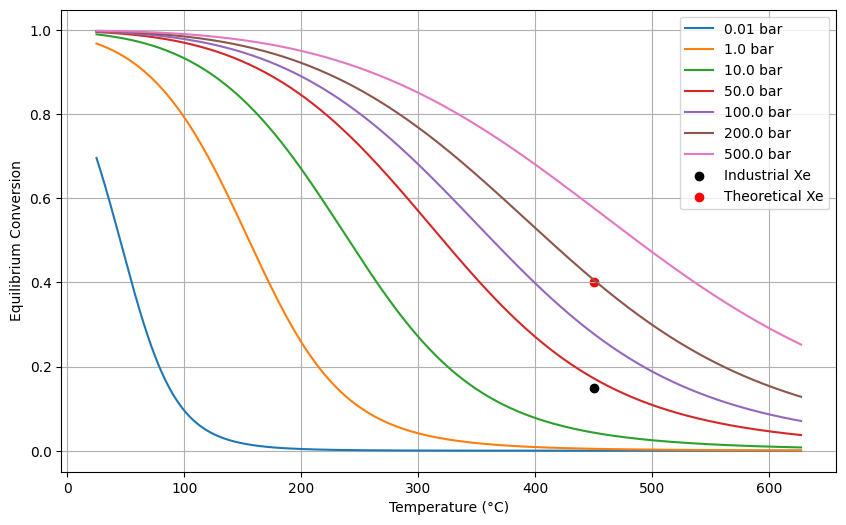

In [14]:

plt.figure(figsize=(10, 6))
for j in range(Xe.shape[0]):
    plt.plot(temps - 273, Xe[j, :], label=f'{P[j]} bar')

plt.scatter(450, 0.15, color='black', marker='o', label='Industrial Xe')
plt.scatter(450, 0.4, color='red', marker='o', label='Theoretical Xe')

plt.xlabel('Temperature (°C)')
plt.ylabel('Equilibrium Conversion')
plt.grid()
plt.legend(loc='upper right')
plt.show()


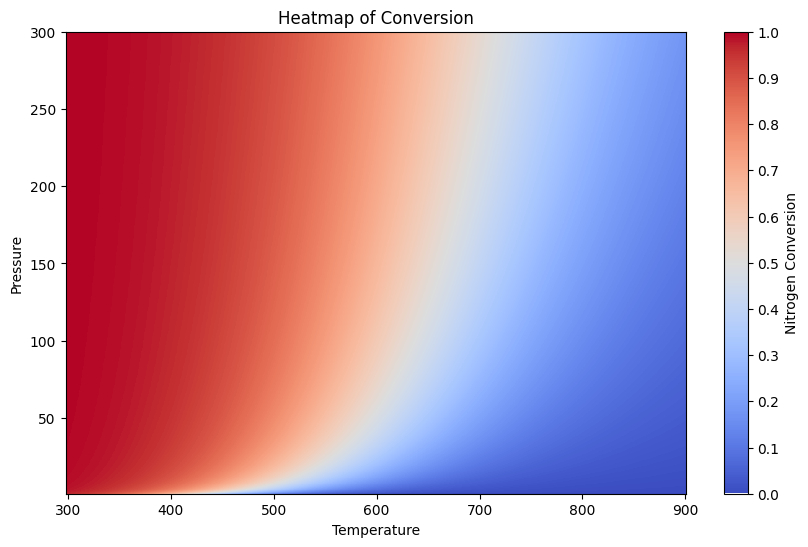

In [15]:

# Create a heatmap
P = np.linspace(1,300,1000) # p array for more pressures in bar
Xe = conversion(ideal_eqm_constant,P)
plt.figure(figsize=(10, 6))
heatmap = plt.pcolormesh(temps, P, Xe, cmap='coolwarm', shading='auto')  # Changed to viridis colormap

# Add colorbar with custom ticks and labels
cbar = plt.colorbar(heatmap, label='Nitrogen Conversion')
cbar.set_ticks(np.arange(0, 1.1, 0.1))
cbar.set_ticklabels([f'{val:.1f}' for val in np.arange(0, 1.1, 0.1)])

# Set axis labels and title
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Heatmap of Conversion')

# Show the plot
plt.show()

